In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch, MeanShift, OPTICS
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors


In [2]:
gs = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\genome-scores.csv', encoding='ISO-8859-1', low_memory=False)
movies = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\movies.csv', encoding='ISO-8859-1', low_memory=False)
gt = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\genome-tags.csv', encoding='ISO-8859-1', low_memory=False)
ratings = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\ratings.csv', encoding='ISO-8859-1', low_memory=False)
links = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\links.csv', encoding='ISO-8859-1', low_memory=False)
tags = pd.read_csv('C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\tags.csv', encoding='ISO-8859-1', low_memory=False)

In [4]:
gs.head()

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [5]:
gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18472128 entries, 0 to 18472127
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 422.8 MB


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int64 
 1   title    86537 non-null  object
 2   genres   86537 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [8]:
gt.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [9]:
gt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [10]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 1.0 GB


In [12]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  86537 non-null  int64  
 1   imdbId   86537 non-null  int64  
 2   tmdbId   86411 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.0 MB


In [14]:
tags.head()

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746


In [15]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328315 entries, 0 to 2328314
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     int64 
 1   movieId    int64 
 2   tag        object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 71.1+ MB


<h3> Создание таблицы popularity для выявления среднего рейтинга на основе ratings

In [3]:
def create_popularity_table():
    movies_path = 'C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\movies.csv'
    ratings_path = 'C:\\Users\\user\\Downloads\\ml-latest\\ml-latest\\ratings.csv'

    movies = pd.read_csv(movies_path, encoding='ISO-8859-1', low_memory=False)
    ratings = pd.read_csv(ratings_path, encoding='ISO-8859-1', low_memory=False)

    avg_ratings = ratings.groupby("movieId")["rating"].mean().reset_index()
    avg_ratings.columns = ["movieId", "ave_rating"]

    popularity = pd.merge(
        movies[["movieId", "title", "genres"]],
        avg_ratings,
        on="movieId"
    )
    return popularity

In [5]:
# Создание таблицы популярности
popularity = create_popularity_table()

<h3> Топ-10 фильмов по популярности в заданном жанре

In [10]:
def get_top_by_genre(genre: str, popularity_df: pd.DataFrame) -> pd.DataFrame:
    # Разделение жанров и фильтрация по заданному
    exploded = popularity_df.assign(genres=popularity_df["genres"].str.split(r"\|")).explode("genres")
    filtered = exploded[exploded["genres"] == genre]
    # Сортировка по рейтингу и выбор топ-10
    top10 = filtered.sort_values("ave_rating", ascending=False).head(10)
    return top10[["title", "genres", "ave_rating"]]

# топ-10 фильмов по жанру 
print(get_top_by_genre("Drama", popularity))

                                                   title genres  ave_rating
72216                            Backyard Wedding (2010)  Drama         5.0
77814                    The Dove's Lost Necklace (1992)  Drama         5.0
54808                            The Jade Pendant (2017)  Drama         5.0
63343                                 The Deadman (1989)  Drama         5.0
31485                                        About Sarah  Drama         5.0
67845                          Story of a Bad Boy (1999)  Drama         5.0
25330                                  Invitation (1952)  Drama         5.0
79526                                    Pendular (2017)  Drama         5.0
77813                     Wanderers of the Desert (1984)  Drama         5.0
60791  All's Well That Ends Well: Shakespeare's Globe...  Drama         5.0


<h3>  Рекомендации по фильму без учета рейтинга

In [12]:
# Преобразование жанров в признаки (TF-IDF)
def get_movie_recommendations(movie_title: str, movies_df: pd.DataFrame) -> list:
    tfidf = TfidfVectorizer(
        tokenizer=lambda x: x.split("|"), 
        token_pattern=None
    )
    genres_matrix = tfidf.fit_transform(movies_df["genres"])
    
    # Прямой расчет схожести (без SVD)
    cosine_sim = cosine_similarity(genres_matrix)
    
    idx = movies_df.index[movies_df["title"] == movie_title].tolist()[0]
    sim_scores = sorted(enumerate(cosine_sim[idx]), key=lambda x: x[1], reverse=True)[1:11]
    return movies_df["title"].iloc[[i[0] for i in sim_scores]].tolist()

In [14]:
# Фильтрация фильмов с высокой популярностью
movie_rating_counts = ratings["movieId"].value_counts()
popular_movies = movie_rating_counts[movie_rating_counts > 100].index
movies_filtered = movies[movies["movieId"].isin(popular_movies)]

In [16]:
print(get_movie_recommendations("Toy Story (1995)", movies_filtered))

['Antz (1998)', 'Toy Story 2 (1999)', 'Adventures of Rocky and Bullwinkle, The (2000)', "Emperor's New Groove, The (2000)", 'Monsters, Inc. (2001)', 'DuckTales: The Movie - Treasure of the Lost Lamp (1990)', 'Wild, The (2006)', 'Shrek the Third (2007)', 'Tale of Despereaux, The (2008)', 'Asterix and the Vikings (AstÃ©rix et les Vikings) (2006)']


In [18]:
# Матрица пользователь-фильм
movie_tag_matrix = gs.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)
movie_tag_matrix_scaled = StandardScaler().fit_transform(movie_tag_matrix)

<h3> Autoencoder + PCA + кластеризация 

In [20]:
# Нормализация
scaler = StandardScaler()
normalized_matrix = scaler.fit_transform(movie_tag_matrix)

In [22]:
input_dim = movie_tag_matrix_scaled.shape[1]
encoding_dim = 32  # Сжатие до 32 признаков

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer=Adam(1e-3), loss='mse')

# Обучение
autoencoder.fit(movie_tag_matrix_scaled, movie_tag_matrix_scaled,
                epochs=20, batch_size=256, shuffle=True, verbose=1)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0776 
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8824 
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8215 
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7895 
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7680 
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7655 
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7523 
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7469 
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7465 
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7412 
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7314 
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7394 
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7271 
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7236 
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7232 
Epoc

In [28]:
encoded_movies = encoder.predict(movie_tag_matrix_scaled)

512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step


In [30]:
# Снижение размерности перед кластеризацией
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_movies)

In [36]:
# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
hdblabels = clusterer.fit_predict(encoded_movies)
print("HDBSCAN:", silhouette_score(encoded_movies, hdblabels))

HDBSCAN: -0.047257222


In [35]:
# Spectral Clustering
sc = SpectralClustering(n_clusters=10, affinity='nearest_neighbors')
labels = sc.fit_predict(encoded_movies)
print("Spectral Clustering:", silhouette_score(encoded_movies, labels))

Spectral Clustering: 0.06550614


In [134]:
# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_movies)
print("KMeans Silhouette:", silhouette_score(encoded_movies, kmeans_labels))

KMeans Silhouette: 0.13042235


In [142]:
# DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(encoded_movies)

In [144]:
print("Кластеры DBSCAN:", np.unique(dbscan_labels, return_counts=True))

Кластеры DBSCAN: (array([-1], dtype=int64), array([16376], dtype=int64))


In [44]:
for eps in [0.5, 1.0, 1.5, 2.0]:
    db = DBSCAN(eps=eps, min_samples=5).fit(encoded_movies)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"eps={eps}: кластеры={n_clusters}, шум={np.sum(labels == -1)}")

eps=0.5: кластеры=0, шум=16376
eps=1.0: кластеры=0, шум=16376
eps=1.5: кластеры=0, шум=16376
eps=2.0: кластеры=0, шум=16376


In [46]:
# Agglomerative
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(encoded_movies)
print("Agglomerative Silhouette:", silhouette_score(encoded_movies, agg_labels))

Agglomerative Silhouette: 0.051336333


In [156]:
# Birch clustering
birch = Birch(n_clusters=3)
birch_labels = birch.fit_predict(encoded_movies)
print("Birch clustering:", silhouette_score(encoded_movies, birch_labels))

Birch clustering: 0.09198905


In [160]:
# OPTICS clustering
optics = OPTICS(min_samples=3)
optics_labels = optics.fit_predict(encoded_movies)
print("OPTICS clusterin:", silhouette_score(encoded_movies, optics_labels))

OPTICS clusterin: -0.4252043


In [164]:
# Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(encoded_movies)
print("Gaussian Mixture Model clustering:", silhouette_score(encoded_movies, gmm_labels))

Gaussian Mixture Model clustering: 0.051690567


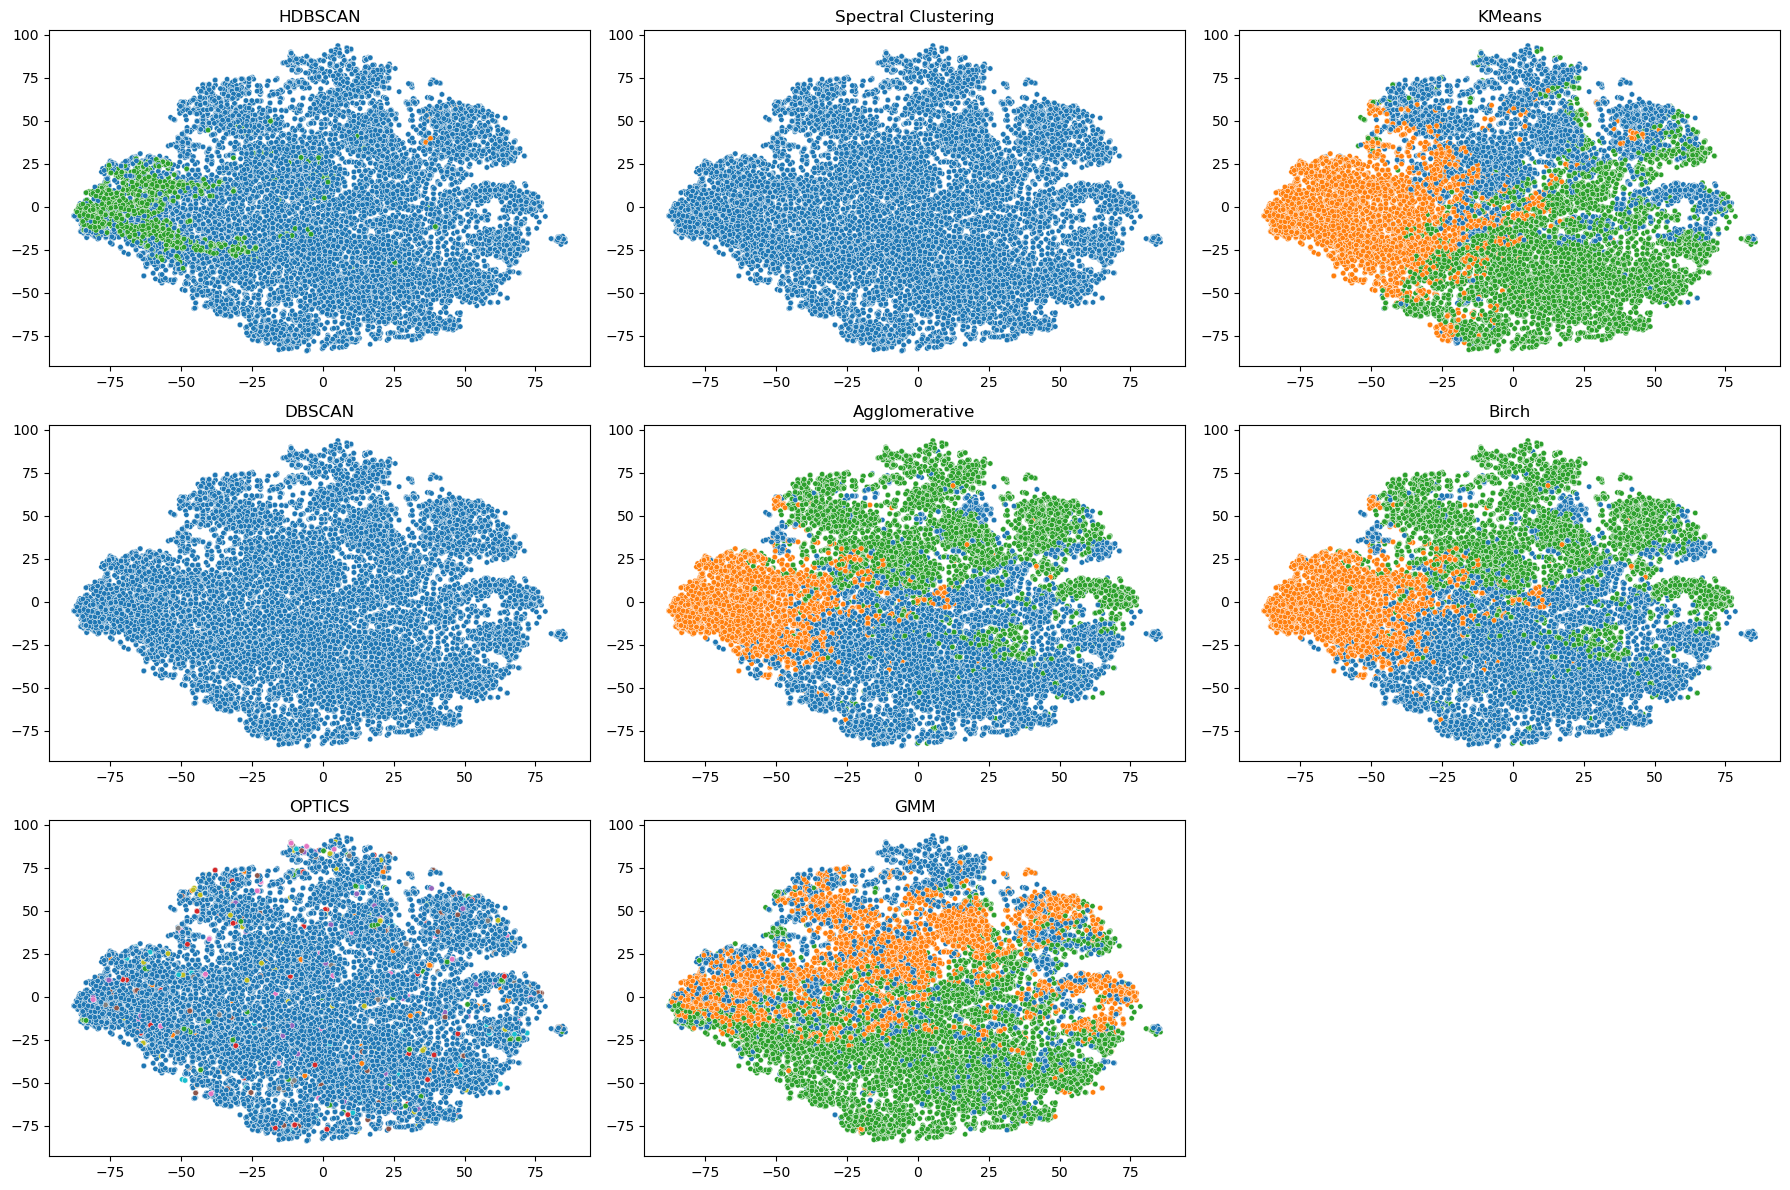

In [166]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(encoded_movies)

# Визуализация
plt.figure(figsize=(18, 12))

clusterings = [
    ("HDBSCAN", hdblabels),
    ("Spectral Clustering", labels),
    ("KMeans", kmeans_labels),
    ("DBSCAN", dbscan_labels),
    ("Agglomerative", agg_labels),
    ("Birch", birch_labels),
    ("OPTICS", optics_labels),
    ("GMM", gmm_labels)
]

for i, (title, labels) in enumerate(clusterings, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='tab10', s=15, legend=False)
    plt.title(title)

plt.tight_layout()
plt.show()

Анализируя все графики можно сказать, что KMeans, Agglomerative Clustering и Birch делит данные достаточно сбалансированно. Agglomerative Clustering и  Birch почти идентичны, скорее всего это связано с тем, что оба метода работают на иерархической кластеризации. Цвета распределены по зонам, что говорит о хорошей сегментации, что не скажешь про HDBSCAN, DBSCAN, OPTICS и Spectral Clustering. В основном там одни шумы, а значит такие методы не особо и подходят для данного датасета, либо можно подобрать другие параметры и попробовать еще раз по эксперементировать. Метод GMM не плох, но видно, что есть перекрытие. Это ожидаемо, т.к. GMM даёт размягчённое разбиение (вероятностное), а не жёсткое.

<h1> User-based</h1>

In [66]:
def get_user_vector(user_id, viewed_movie_ids, ratings_df, movie_vectors, movie_id_map, rating_threshold=4.0):
    """
    Строит user_vector в зависимости от количества рейтингов и их качества.
    
    Параметры:
    - user_id: ID пользователя
    - viewed_movie_ids: список просмотренных movieId (может включать фильмы без оценки)
    - ratings_df: DataFrame с колонками ['userId', 'movieId', 'rating']
    - movie_vectors: массив векторов фильмов 
    - movie_id_map: словарь movieId → индекс в movie_vectors
    - rating_threshold: рейтинг, выше которого считается "положительный"
    
    Возвращает:
    - user_vector: numpy-вектор предпочтений пользователя
    - mode: 'view_based' или 'rating_based' (для дальнейшей логики)
    """

    for movie_id in viewed_movie_ids:
        original_movie_row = movies[movies['movieId'] == movie_id]
        if original_movie_row.empty:
            continue
        
        original_movie_title = original_movie_row['title'].values[0]
        original_movie_genres = original_movie_row['genres'].values[0]
        original_genres_set = set(original_movie_genres.split('|'))
    
        print(f"Получаем рекомендации для фильма с ID: {movie_id} (Название: {original_movie_title}) (Жанры: {original_movie_genres})")

    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    rated_movie_ids = set(user_ratings['movieId'])
    positive_ratings = user_ratings[user_ratings['rating'] >= rating_threshold]
    
    # Используем рейтинговую стратегию, если достаточно данных
    if len(user_ratings) >= 5 and len(positive_ratings) >= 3:
        vectors = []
        weights = []
        for _, row in user_ratings.iterrows():
            mid = row['movieId']
            if mid in movie_id_map:
                vectors.append(movie_vectors[movie_id_map[mid]])
                weights.append(row['rating'])  # Вес = рейтинг
        if vectors:
            weighted_avg = np.average(vectors, axis=0, weights=weights)
            return weighted_avg, 'rating_based'
    else:
        # Используем просмотренные фильмы
        vectors = []
        for mid in viewed_movie_ids:
            if mid in movie_id_map:
                vectors.append(movie_vectors[movie_id_map[mid]])
        if vectors:
            avg_vector = np.mean(vectors, axis=0)
            return avg_vector, 'view_based'
    
    return None, 'no_data'

In [68]:
def recommend_for_user(user_vector, movie_vectors, movies_df, clustering_labels=None, top_n=10, mode='cosine'):
    """
    Делает рекомендации на основе вектора пользователя тремя способами:
    - mode='cosine': простое косинусное сходство
    - mode='knn': KNN по user_vector
    - mode='cluster': рекомендации из кластера пользователя

    Параметры:
    - user_vector: numpy-вектор предпочтений пользователя
    - movie_vectors: матрица векторов фильмов
    - movies_df: DataFrame с колонками ['movieId', 'title', 'genres']
    - clustering_labels: массив меток кластеров для каждого фильма (нужен для mode='cluster')
    - top_n: количество рекомендаций
    - mode: 'cosine' | 'knn' | 'cluster'

    Возвращает:
    - DataFrame с колонками ['movieId', 'title', 'genres', 'score']
    """


    if user_vector is None:
        return pd.DataFrame(columns=['movieId', 'title', 'genres', 'score'])

    if mode == 'cosine':
        similarities = cosine_similarity([user_vector], movie_vectors)[0]
        top_indices = similarities.argsort()[::-1][:top_n]
        scores = similarities[top_indices]

    elif mode == 'knn':
        knn = NearestNeighbors(n_neighbors=top_n, metric='cosine')
        knn.fit(movie_vectors)
        distances, indices = knn.kneighbors([user_vector])
        top_indices = indices[0]
        scores = 1 - distances[0]  # cos-дистанция -> сходство

    elif mode == 'cluster':
        if clustering_labels is None:
            raise ValueError("Для кластеризации необходимо передать clustering_labels")

        from sklearn.metrics.pairwise import euclidean_distances
        # Определяем ближайший кластер
        cluster_id = clustering_labels[np.argmin(euclidean_distances([user_vector], movie_vectors))]
        cluster_indices = np.where(clustering_labels == cluster_id)[0]
        cluster_vectors = movie_vectors[cluster_indices]

        similarities = cosine_similarity([user_vector], cluster_vectors)[0]
        top_indices_in_cluster = similarities.argsort()[::-1][:top_n]
        top_indices = cluster_indices[top_indices_in_cluster]
        scores = similarities[top_indices_in_cluster]

    else:
        raise ValueError("Неверный mode. Используйте: 'cosine', 'knn', 'cluster'")

    result_df = movies_df.iloc[top_indices].copy()
    result_df['score'] = scores
    return result_df[['movieId', 'title', 'genres', 'score']]

In [70]:
def ensemble_user_recommendations(user_vector, movie_vectors, movies_df, clustering_labels=None, top_n=10):
    """
    Собирает рекомендации из 3 методов: cosine, knn, cluster → делает ensemble.
    
    Возвращает top_n рекомендаций по объединённому score.
    """

   

    rec_cosine = recommend_for_user(user_vector, movie_vectors, movies_df, mode='cosine', top_n=top_n * 2)
    rec_knn = recommend_for_user(user_vector, movie_vectors, movies_df, mode='knn', top_n=top_n * 2)
    rec_cluster = recommend_for_user(user_vector, movie_vectors, movies_df, clustering_labels=clustering_labels, mode='cluster', top_n=top_n * 2)

    # Объединяем все рекомендации
    all_recs = pd.concat([rec_cosine, rec_knn, rec_cluster], axis=0)

    # Суммируем score по movieId
    combined = (
        all_recs.groupby('movieId')
        .agg({
            'score': 'sum',
            'title': 'first',
            'genres': 'first'
        })
        .reset_index()
    )

    # Сортируем и выбираем топ-N
    combined = combined.sort_values('score', ascending=False).head(top_n)
    return combined[['movieId', 'title', 'genres', 'score']]

In [80]:
user_vector, mode = get_user_vector(
    user_id=1,
    viewed_movie_ids=[1, 10, 100],
    ratings_df=ratings,
    movie_vectors=encoded_movies,
    movie_id_map={mid: idx for idx, mid in enumerate(movies['movieId'])}
)
final_recommendations = ensemble_user_recommendations(
    user_vector,
    encoded_movies,
    movies,
    clustering_labels=agg_labels,
    top_n=10
)
final_recommendations

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


,movieId,title,genres,score
26,80693,It's Kind of a Funny Story (2010),Comedy|Drama,2.963916
5,1055,Shadow Conspiracy (1997),Thriller,2.962672
28,82017,"Viking, The (1928)",Action|Adventure|Drama,2.961642
3,912,Casablanca (1942),Drama|Romance,2.960903
23,79739,"Thorn in the Heart, The (2009)",Documentary,2.959536
27,81027,Autumn Ball (SÃ¼gisball) (2007),Drama,2.958819
2,820,"Death in the Garden (Mort en ce jardin, La) (1...",Drama,2.956290
20,77264,Ballet Shoes (2007),Children|Drama,2.954681
19,74685,"Crazies, The (2010)",Action|Drama|Horror|Sci-Fi|Thriller,2.954044
8,4130,Maid to Order (1987),Comedy|Fantasy,2.953567


<h1> Гибридный подход</h1>

In [83]:
def hybrid_recommendations(
    user_vector,
    movie_vectors,
    movies_df,
    content_reference_ids,
    movie_id_map,
    clustering_labels=None,
    top_n=10,
    content_weight=0.5,
    user_weight=0.5
):
    """
    Возвращает рекомендации, объединяя content-based и user-based подходы.

    Параметры:
    - user_vector: вектор предпочтений пользователя
    - movie_vectors: матрица векторов фильмов
    - movies_df: DataFrame с фильмами
    - content_reference_ids: список movieId, на основе которых делать content-based рекомендации
    - movie_id_map: словарь movieId -> индекс
    - clustering_labels: метки кластеров
    - top_n: сколько фильмов вернуть
    - content_weight: вес content-based рекомендаций
    - user_weight: вес user-based рекомендаций

    Возвращает:
    - DataFrame с рекомендациями
    """
    
    # Content-based рекомендации
    content_vectors = []
    for mid in content_reference_ids:
        if mid in movie_id_map:
            content_vectors.append(movie_vectors[movie_id_map[mid]])
    
    if content_vectors:
        content_vector = np.mean(content_vectors, axis=0)
        content_scores = cosine_similarity([content_vector], movie_vectors)[0]
    else:
        content_scores = np.zeros(len(movie_vectors))

    # User-based рекомендации
    if user_vector is not None:
        user_scores = cosine_similarity([user_vector], movie_vectors)[0]
    else:
        user_scores = np.zeros(len(movie_vectors))

    # Гибридные оценки
    final_scores = content_weight * content_scores + user_weight * user_scores

    # Получаем топ-N
    top_indices = final_scores.argsort()[::-1][:top_n]
    top_scores = final_scores[top_indices]

    recommendations = movies_df.iloc[top_indices].copy()
    recommendations['score'] = top_scores
    return recommendations[['movieId', 'title', 'genres', 'score']]

In [85]:
hybrid_recs = hybrid_recommendations(
    user_vector=user_vector,
    movie_vectors=encoded_movies,
    movies_df=movies,
    content_reference_ids=[1, 10, 100],  # можно использовать те же фильмы
    movie_id_map={mid: idx for idx, mid in enumerate(movies['movieId'])},
    top_n=10,
    content_weight=0.4,
    user_weight=0.6
)
hybrid_recs

,movieId,title,genres,score
4161,4265,Driven (2001),Action|Thriller,0.979269
891,912,Casablanca (1942),Drama|Romance,0.976096
4027,4130,Maid to Order (1987),Comedy|Fantasy,0.975906
12699,62293,"Duchess, The (2008)",Drama|Romance,0.975607
1031,1055,Shadow Conspiracy (1997),Thriller,0.975555
15286,80693,It's Kind of a Funny Story (2010),Comedy|Drama,0.974960
15573,82017,"Viking, The (1928)",Action|Adventure|Drama,0.974715
5481,5589,Indian Summer (1993),Comedy|Drama,0.974628
13535,69964,"Giant of Marathon, The (Battaglia di Maratona,...",Action|Drama|War,0.974511
7696,8255,Chaos (Kaosu) (1999),Crime|Mystery|Thriller,0.974185
